In [66]:
import os
import string
from glob import glob

import dynamic_properties as dynprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from tqdm import tqdm

LOG2 = True
K_MAX = 6
NO_STATES = 4
MAX_LAG = 100
SAMPLING_FREQ = 250.0

plt.style.use("papers")

In [56]:
# dynstats = pd.DataFrame()
all_segmentations = []
all_topomaps = []
subj_ids = []
types = []

for file in tqdm(sorted(glob("ms_results/*.npz"))):
    splitted = os.path.basename(file).split("_")
    subject_id = splitted[0]
    if len(splitted) == 3:
        typ = "VAR"
    else:
        typ = splitted[2] + " minute"
    sequence = np.load(file)["latent_segmentation"]
    all_segmentations.append(sequence)
    topo = np.load(file)["latent_maps"]
    all_topomaps.append(topo)
    subj_ids.append(subject_id)
    types.append(typ)

array_segm = np.empty((len(subj_ids), max([len(arr) for arr in all_segmentations])))
array_segm[:] = np.nan
for i, arr in enumerate(all_segmentations):
    array_segm[i, : len(arr)] = arr
array_topomaps = np.empty(
    (
        len(subj_ids),
        NO_STATES,
        max([arr.shape[1] for arr in all_topomaps]),
    )
)
array_topomaps[:] = np.nan
for i, arr in enumerate(all_topomaps):
    array_topomaps[i, :, : arr.shape[1]] = arr

    # empirical_dist = dynprop.empirical_distribution(sequence, NO_STATES)
    # trans_mat = dynprop.empirical_trans_mat(sequence, NO_STATES)
    # mixing_time = dynprop.mixing_time(trans_mat)
    # entropy = dynprop.H_1(sequence, NO_STATES, log2=LOG2)
    # max_entropy = dynprop.max_entropy(NO_STATES, log2=LOG2)
    # ent_rate, excess_ent = dynprop.excess_entropy_rate(
    #     sequence, NO_STATES, kmax=K_MAX, log2=LOG2
    # )
    # mc_ent_rate = dynprop.markov_chain_entropy_rate(
    #     empirical_dist, trans_mat, log2=LOG2
    # )
    # aif1 = dynprop.lagged_mutual_information(
    #     sequence,
    #     NO_STATES,
    #     max_lag=MAX_LAG,
    #     log2=LOG2,
    #     pbar=False,
    # )
    # _, aif_1st_peak_time = dynprop.find_1st_aif_peak(aif1, SAMPLING_FREQ)
    # dynstats = pd.concat(
    #     [
    #         dynstats,
    #         pd.DataFrame(
    #             {
    #                 "subject_id": subject_id,
    #                 "type": typ,
    #                 "mixing time": mixing_time,
    #                 "entropy": entropy,
    #                 "max entropy": max_entropy,
    #                 "entropy_rate": ent_rate,
    #                 "MC entropy rate": mc_ent_rate,
    #                 "AIF 1st peak": aif_1st_peak_time,
    #             },
    #             index=[0],
    #         ),
    #     ]
    # )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 449.37it/s]


In [68]:
segmentations = xr.DataArray(
    array_segm,
    dims=["stack", "time"],
    coords={
        "subject_id": ("stack", subj_ids),
        "type": ("stack", types),
        "time": np.arange(
            0,
            array_segm.shape[1] * (1.0 / SAMPLING_FREQ),
            1.0 / SAMPLING_FREQ,
        ),
    },
)

topo_maps = xr.DataArray(
    array_topomaps,
    dims=["stack", "latent map", "channels"],
    coords={
        "subject_id": ("stack", subj_ids),
        "type": ("stack", types),
        "latent map": list(string.ascii_uppercase)[:NO_STATES],
        "channels": np.arange(array_topomaps.shape[2]),
    },
)
segmentations.to_netcdf("ms_results/segmentations.nc")
topo_maps.to_netcdf("ms_results/topomaps.nc")

In [4]:
stats = pd.read_csv("ms_results/stats.csv", index_col=0)

In [11]:
stats[["subject_id", "type"]] = (
    stats["subject_id"]
    .str.split("_", expand=True)
    .drop([1, 3], axis=1)
    .replace({"1st": "1st minute", "2nd": "2nd minute", "var": "VAR"})
)
stats

,subject_id,latent map,var_GFP,var_total,template_corr,coverage,occurrence,lifespan,transition->A,transition->B,transition->C,transition->D,type
0,sub-010005,A,0.811487,0.757683,0.916253,0.274382,11.915872,23.009790,0.826245,0.066586,0.046902,0.060267,1st minute
1,sub-010005,B,0.811487,0.757683,0.903176,0.267582,12.849143,20.824903,0.048331,0.807922,0.037867,0.105879,1st minute
2,sub-010005,C,0.811487,0.757683,0.966968,0.246384,12.765816,19.300261,0.078734,0.090368,0.792749,0.038149,1st minute
3,sub-010005,D,0.811487,0.757683,0.891551,0.211653,13.582428,15.597052,0.072756,0.051339,0.132598,0.743307,1st minute
0,sub-010007,A,0.803515,0.747765,0.859554,0.242584,16.765549,14.479602,0.723550,0.088761,0.103050,0.084639,1st minute
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,sub-010318,D,0.845275,0.788846,0.879088,0.250927,19.579167,12.816379,0.174832,0.025505,0.111772,0.687890,VAR
0,sub-010305,A,0.802283,0.753031,0.744479,0.225240,15.021667,14.994730,0.733229,0.137751,0.071332,0.057687,VAR
1,sub-010305,B,0.802283,0.753031,0.958911,0.265887,15.154167,17.545450,0.068576,0.772021,0.079482,0.079921,VAR
2,sub-010305,C,0.802283,0.753031,0.940342,0.251947,13.866667,18.169231,0.078879,0.061891,0.779848,0.079382,VAR


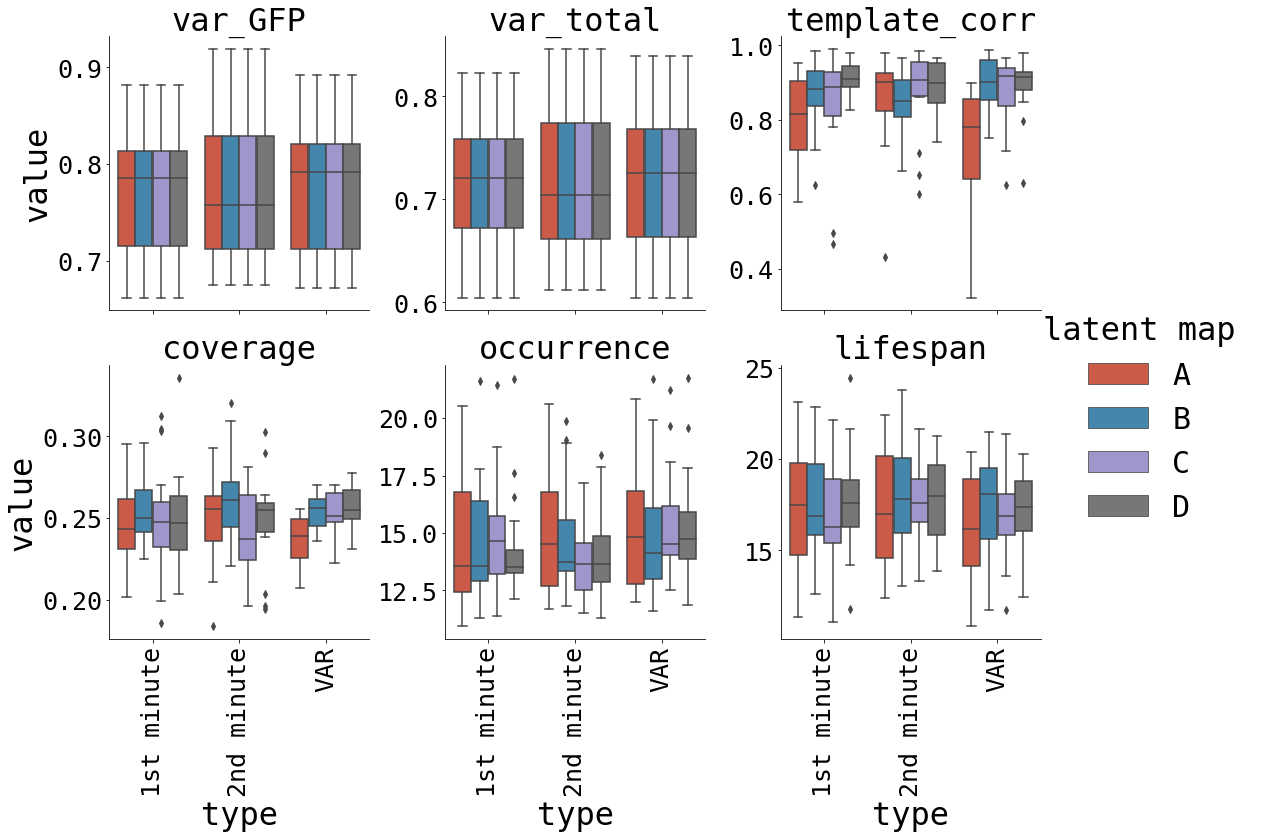

In [20]:
melt = stats.melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

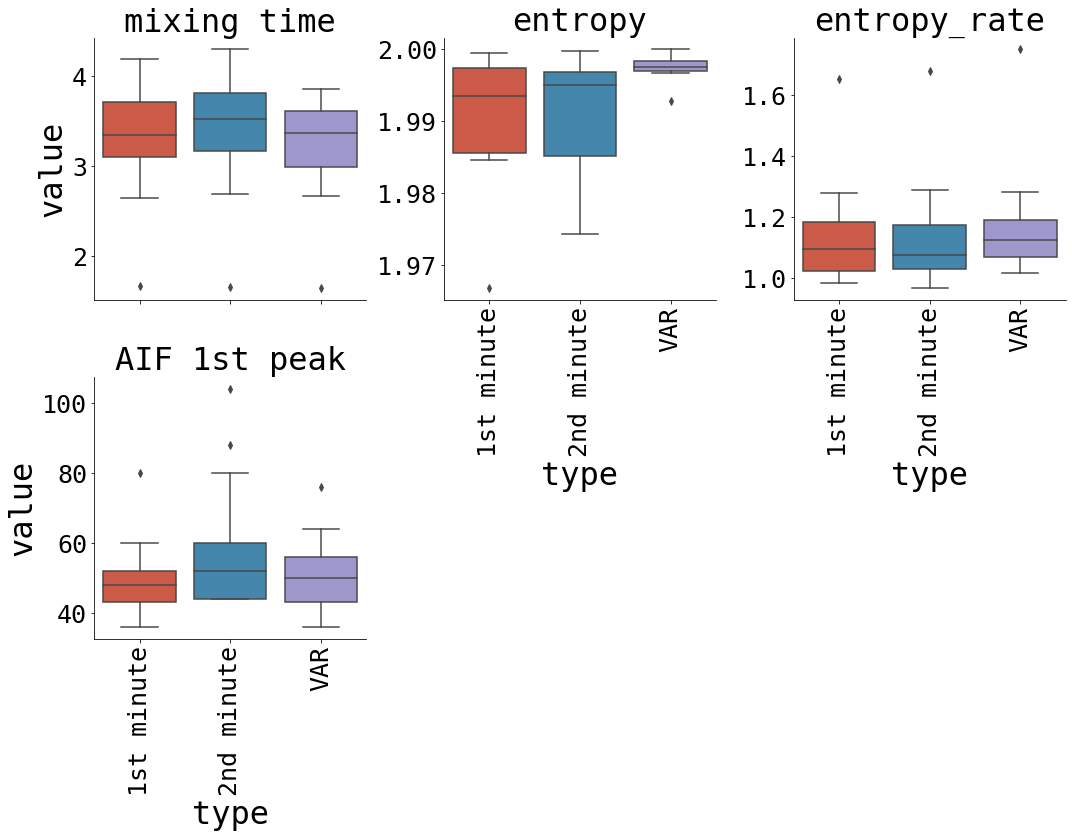

In [45]:
dynstats
g = sns.catplot(
    data=dynstats.melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=3,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [98]:
# topo_maps = topo_maps.set_index({"stack": ["subject_id", "type"]})
all_corrs = []
TYPES = ["1st minute", "2nd minute", "VAR"]
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topo_maps.sel({"type": typ1}),
                topo_maps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

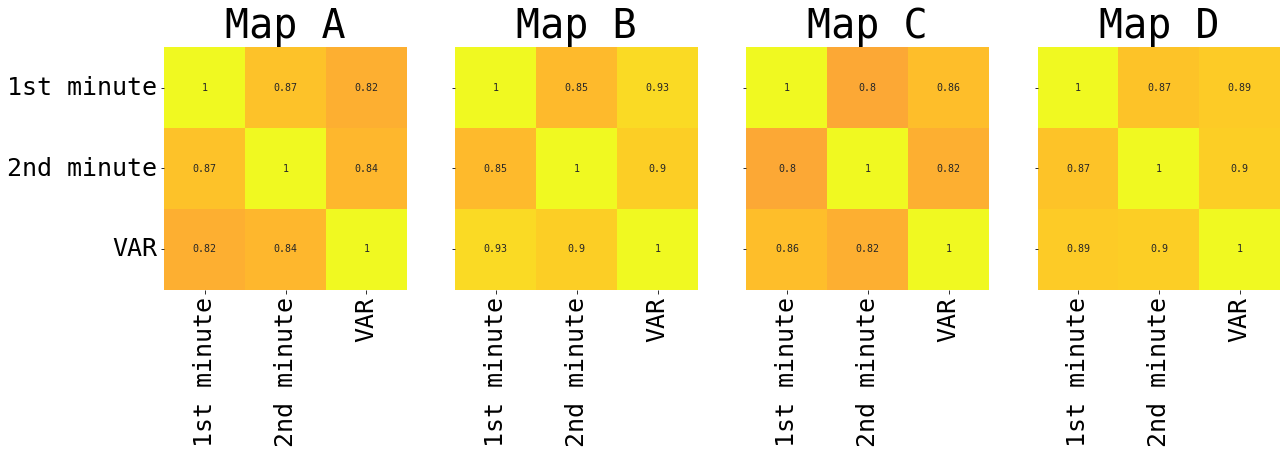

In [151]:
corrs = np.abs(xr.combine_by_coords(all_corrs))

fig, axs = plt.subplots(nrows=1, ncols=4, squeeze=True, figsize=(20, 9), sharey=True)
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot=True,
        vmin=0,
        vmax=1,
    )
    axs[i].set_xticks(np.arange(3) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(3) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [133]:
all_corrs2 = []
TYPES = ["1st minute", "2nd minute", "VAR"]
SUBJECTS = np.unique(topo_maps.coords["subject_id"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        for subj1 in SUBJECTS:
            for subj2 in SUBJECTS:
                all_corrs2.append(
                    xr.corr(
                        topo_maps.sel({"type": typ1, "subject_id": subj1}),
                        topo_maps.sel({"type": typ2, "subject_id": subj2}),
                        dim="channels",
                    )
                    .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
                    .expand_dims(["type1", "type2", "subj1", "subj2"])
                )

In [148]:
combined = np.abs(xr.combine_by_coords(all_corrs2))

Text(250.17015810276683, 0.5, 'VAR $\\to$ 2nd min')

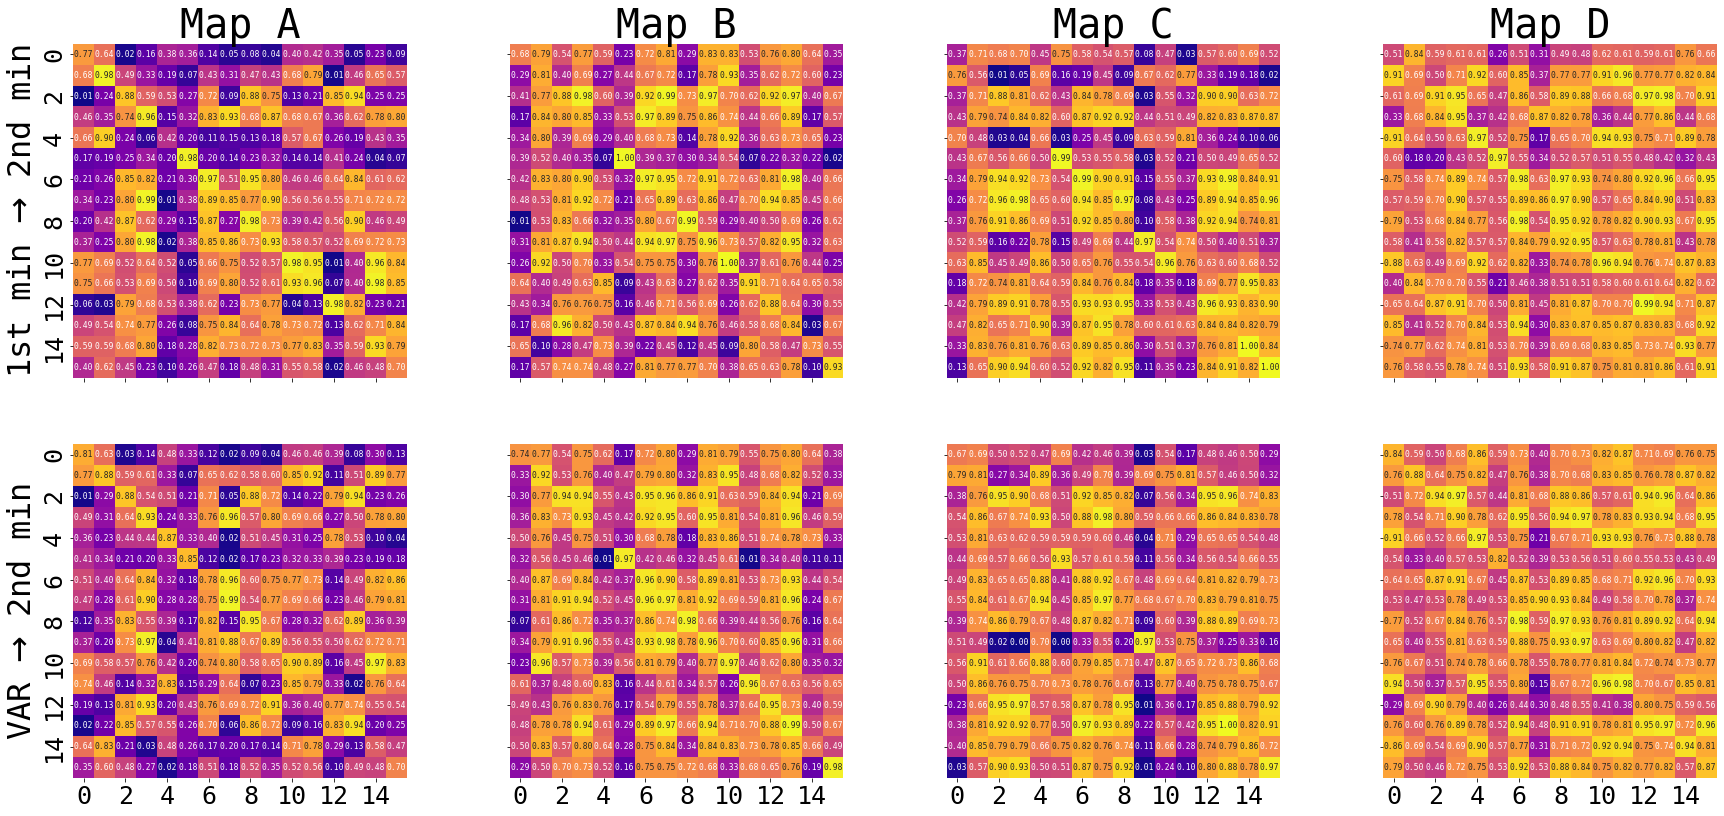

In [161]:
fig, axs = plt.subplots(nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st minute", "VAR"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd minute", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            annot=True,
            fmt=".2f",
            annot_kws={"size": 8},
            vmin=0,
            vmax=1,
        )
    # axs[0, i].set_xticks(np.arange(3) + 0.5, TYPES, rotation=90)
    # axs[0, i].set_yticks(np.arange(3) + 0.5, TYPES, rotation=0)
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st min $\to$ 2nd min")
axs[1, 0].set_ylabel(r"VAR $\to$ 2nd min")